In [42]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import LambdaLR

In [43]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import LambdaLR

### Load Data

In [44]:
df = pd.read_csv("./Students_Grading_Dataset.csv")

## Manually select Cols (attribute)

In [45]:
unimportant_attribute = ['Student_ID', 'First_Name', 'Last_Name', 'Email', 'Participation_Score']

filtered_df = df.drop(unimportant_attribute, axis=1)
filtered_df

,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,Female,22,Engineering,52.29,55.03,57.82,84.22,74.06,85.90,56.09,F,6.2,No,Yes,High School,Medium,5,4.7
1,Male,18,Engineering,97.27,97.23,45.80,NaN,94.24,55.65,50.64,A,19.0,No,Yes,NaN,Medium,4,9.0
2,Male,24,Business,57.19,67.05,93.68,67.70,85.70,73.79,70.30,D,20.7,No,Yes,Master's,Low,6,6.2
3,Female,24,Mathematics,95.15,47.79,80.63,66.06,93.51,92.12,61.63,A,24.8,Yes,Yes,High School,High,3,6.7
4,Female,23,CS,54.18,46.59,78.89,96.85,83.70,68.42,66.13,F,15.4,Yes,Yes,High School,High,2,7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Male,19,Business,NaN,82.15,60.33,80.09,99.32,58.42,85.21,D,25.5,No,Yes,High School,Low,10,8.3
4996,Male,19,Business,65.11,86.31,49.80,NaN,88.08,60.87,95.96,C,5.0,No,Yes,NaN,Medium,4,4.0
4997,Female,24,CS,87.54,63.55,64.21,94.28,50.19,82.65,54.25,A,24.8,Yes,No,High School,Medium,4,6.3
4998,Male,23,CS,92.56,79.79,94.28,81.20,61.18,94.29,55.84,A,16.1,Yes,Yes,Bachelor's,Low,1,8.4


In [46]:
category_vars = ['Gender', 'Department', 'Grade', 'Extracurricular_Activities', 'Internet_Access_at_Home', 'Parent_Education_Level', 'Family_Income_Level']
# numerical_score_vars = ['Attendance (%)', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score', 'Projects_Score', 'Total_Score', 'Stress_Level (1-10)']
numerical_score_vars = ['Attendance (%)', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Projects_Score', 'Total_Score']
numerical_scalar_vars = list(set(filtered_df.columns) - set(category_vars) - set(numerical_score_vars))

## Separate rows with-Nan and without-Nan

In [47]:
nan_rows = filtered_df.isna().any(axis=1)

# Nan rows
df_nan = filtered_df[nan_rows]
print(f"row with Nan: {df_nan.shape}")

# Complete rows
df_complete = filtered_df[~nan_rows]
print(f"row without Nan: {df_complete.shape}")

row with Nan: (2419, 18)
row without Nan: (2581, 18)


In [48]:
df_train, df_valid, _, _ = train_test_split(df_complete, df_complete, test_size=0.3, random_state=0)

df_train_id = [i for i in range(len(df_train))]
df_valid_id = [i for i in range(len(df_valid))]

print(f"df_train: {df_train.shape}")
print(f"df_valid: {df_valid.shape}")

# print(f"df_train_id: {df_train_id}")
# print(f"df_valid_id: {df_valid_id}")


df_train: (1806, 18)
df_valid: (775, 18)


## Preprocessing: 
1. category to numerical
2. max-min norm

In [49]:
def category_to_numerical(data):
    le = LabelEncoder()
    le.fit(data)
    num_data = le.transform(data)
    
    return num_data, le

def max_min_norm_score(data, train_params = None, process_type = 'train'):
    
    if process_type == 'train':
        data_max = 100
        data_min = 0
    else:
        data_max = 100
        data_min = 0
        
    norm_data = (data - data_min) / (data_max - data_min)    
    
    if process_type == 'train':
        return norm_data, data_max, data_min
    else:
        return norm_data
    
def max_min_norm_scalar(data, train_params = None, process_type = 'train'):
    
    if process_type == 'train':
        data_max = 10
        data_min = 0
    else:
        data_max = 10
        data_min = 0
        
    norm_data = (data - data_min) / (data_max - data_min)    
    
    if process_type == 'train':
        return norm_data, data_max, data_min
    else:
        return norm_data

    
def preprocessing(df, train_params = None, process_type = 'train'):
    
    new_df = pd.DataFrame()
    
    if process_type == 'train':
        train_params = {}
        category_var_len = {}

    # Category 
    for cat_name in category_vars:
        cat_var = df[cat_name]
        if process_type == 'train':
            cat_var, le = category_to_numerical(cat_var)
            train_params[f'{cat_name}_le'] = le
            category_var_len[f'{cat_name}'] = len(np.unique(cat_var))
        else:
            cat_var = train_params[f'{cat_name}_le'].transform(cat_var)
        new_df[f'{cat_name}'] = cat_var
    
    # Numerical score
    for num_name in numerical_score_vars:
        num_var = df[num_name]
        # if process_type == 'train':
        #     num_var, data_max, data_min = max_min_norm_score(num_var, process_type = 'train')
        #     train_params[num_name] = [data_max, data_min]
        # else:
        #     num_var = max_min_norm_score(num_var, train_params, process_type = 'valid')
        new_df[num_name] = num_var.values
    
    # Numerical scalar
    for num_name in numerical_scalar_vars:
        num_var = df[num_name]
        # num_var = np.log(num_var)
        # if process_type == 'train':
        #     num_var, data_max, data_min = max_min_norm_scalar(num_var, process_type = 'train')
        #     train_params[num_name] = [data_max, data_min]
        # else:
        #     num_var = max_min_norm_scalar(num_var, train_params, process_type = 'valid')
        new_df[num_name] = num_var.values
        
        
    if process_type == 'train':
        return new_df, train_params, category_var_len
    else:
        return new_df


In [50]:
processed_df_train, train_params, category_var_len = preprocessing(df_train, process_type = 'train')
# train_params
print(f"category_var_len: {category_var_len}")
print(f"processed_df_train: {processed_df_train.shape}")

cols_name = processed_df_train.columns
processed_df_train.head()

category_var_len: {'Gender': 2, 'Department': 4, 'Grade': 5, 'Extracurricular_Activities': 2, 'Internet_Access_at_Home': 2, 'Parent_Education_Level': 4, 'Family_Income_Level': 3}
processed_df_train: (1806, 18)


,Gender,Department,Grade,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Projects_Score,Total_Score,Study_Hours_per_Week,Age,Sleep_Hours_per_Night,Stress_Level (1-10)
0,1,1,1,1,1,0,1,89.89,42.55,50.45,55.28,76.34,57.83,74.26,27.8,24,8.4,4
1,1,3,2,0,1,3,2,55.62,81.90,45.43,53.80,92.15,63.71,89.95,5.9,23,6.9,2
2,1,1,4,0,1,1,1,63.09,60.57,56.80,53.42,82.88,56.71,59.43,18.9,19,4.9,7
3,1,2,2,1,1,1,2,60.77,98.69,45.50,57.71,53.39,55.16,83.37,16.8,19,8.2,10
4,0,2,1,0,1,1,2,95.90,84.59,68.58,52.04,63.89,65.54,88.54,6.3,21,8.9,6


In [51]:
processed_df_valid = preprocessing(df_valid, train_params, process_type = 'valid')
print(f"processed_df_valid: {processed_df_valid.shape}")
processed_df_valid.head()

processed_df_valid: (775, 18)


,Gender,Department,Grade,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Projects_Score,Total_Score,Study_Hours_per_Week,Age,Sleep_Hours_per_Night,Stress_Level (1-10)
0,1,3,2,0,1,2,1,51.54,64.04,50.02,87.28,96.99,82.58,88.88,17.1,19,8.5,8
1,1,1,1,1,1,2,1,99.70,93.76,61.42,54.57,75.76,53.97,64.68,7.0,18,4.1,8
2,1,3,2,0,1,3,0,61.51,73.15,41.90,55.37,55.64,78.62,54.29,19.1,24,6.9,9
3,1,1,3,1,1,2,1,52.28,82.12,99.62,55.18,50.23,83.34,65.64,24.4,21,6.4,7
4,1,2,0,0,1,0,2,94.74,53.40,62.16,83.29,79.03,62.50,65.57,10.6,23,7.4,3


In [52]:
BATCH_SIZE = 256
MASK_RATIO = 30

In [53]:
def masking_helper(data, MASK_RATIO, seed = 42):
    np.random.seed(seed)

    rows, cols = data.shape
    
    # define mask/unmask ratio
    unmask_ratio = ((100 - MASK_RATIO) * cols) // 100
    mask_ratio = cols - unmask_ratio

    # create random index
    shuff_idx = np.array([np.random.permutation(cols) for _ in range(rows)])
    
    # define mask/unmask idx
    mask_idx = shuff_idx[:, :mask_ratio]
    unmask_idx = shuff_idx[:, mask_ratio:]
    
    mask_idx.sort(axis=1)
    unmask_idx.sort(axis=1)
    
    # create new_data (contain unmask cols, but remove mask cols)
    new_data = np.zeros((rows, unmask_ratio))
    for i in range(rows):
        new_data[i] = data[i][unmask_idx[i]]
        
    return new_data, unmask_idx, mask_idx, unmask_ratio

def masking_fn(data, seed):
    sample_size = len(data)

    new_data, unmask_idx, mask_idx, unmask_ratio = masking_helper(data, MASK_RATIO, seed)
        
    X = [[],[],[],[]]
    Y = []

    for i in range(sample_size):
        X[0].append(new_data[i]) # unmask data
        X[1].append(unmask_idx[i]) # unmask id
        X[2].append(mask_idx[i]) # mask id
        X[3].append(np.ones(unmask_ratio)) # len = unmask, serve as random noisee in VAE
        Y.append(data[i][list(unmask_idx[i])+list(mask_idx[i])]) # label (unmask + mask)

    X[0] = torch.tensor(np.array(X[0])) # unmask data
    X[1] = torch.tensor(np.array(X[1])) # unmask id
    X[2] = torch.tensor(np.array(X[2])) # mask id
    X[3] = torch.tensor(np.array(X[3])) # latent space
    
    Y = torch.tensor(np.array(Y))
    

    return X, Y

In [54]:
def collate_fn_train(data_wtih_type):

    # data
    data = [dat[0] for dat in data_wtih_type]
    data = np.array(data)
    
    # data type: training/valid
    data_type = data_wtih_type[0][1]

    if data_type == 'training':
        seed = np.random.randint(5, size=1)
    else:
        seed = 42

    data, label = masking_fn(data, seed)

    return data, label

class TableDataset(Dataset):
    def __init__(self, data, data_type = 'training'):
        self.data = data
        self.data_type = data_type
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, id):
        dat = self.data.iloc[id, :]
        dat = np.array(dat)
        return dat, self.data_type
        

        

In [55]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

augmented_processed_df_train = pd.concat([processed_df_train, processed_df_train, processed_df_train], axis = 0)
train_dataset = TableDataset(augmented_processed_df_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False, collate_fn = collate_fn_train)


valid_dataset = TableDataset(processed_df_valid, data_type = 'valid')
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn = collate_fn_train)

In [56]:
class positional_encoder(nn.Module):
    def __init__(self, encoder_emb_dim, num_variables):
        super().__init__()
        
        self.encoder_emb_dim = encoder_emb_dim
        self.pos_emb = nn.Embedding(num_variables, encoder_emb_dim)
        
    def forward(self, unmasked_data, unmasked_idx, masked_idx):
        
        unmasked_pos_info = self.pos_emb(unmasked_idx.long()).float()

        masked_pos_info = self.pos_emb(masked_idx.long()).float()

        unmasked_data = torch.unsqueeze(unmasked_data, dim = 2) # (batch_size, num_vars, 1)
        unmasked_data_w_pos = torch.cat([unmasked_data, unmasked_pos_info], dim = 2) # (batch_size, num_vars, 1 + encoder_emb_dim)
        
        return unmasked_data_w_pos, masked_pos_info
        

In [57]:
class Head(nn.Module):
    def __init__(self, num_head, encoder_emb_dim, dropout):
        super().__init__()
        self.num_head = num_head
        self.encoder_emb_dim = encoder_emb_dim

        # up_emb_size * 3 for qkv
        self.qkv_fn = nn.Linear(self.encoder_emb_dim, self.encoder_emb_dim * 3, bias=False)
        self.proj_qkv = nn.Linear(self.encoder_emb_dim, self.encoder_emb_dim, bias = False)
                
        # other
        self.att_dropout = nn.Dropout(dropout)
        
    def forward(self, x):

        batch_size, num_vars, _ = x.shape

        # qkv: up_emb_size * 3
        x = self.qkv_fn(x) 
        q, k, v = x.split(self.encoder_emb_dim, dim = 2) 
        
        # split head: each shape = [batch_size, num_head, num_vars(seq_len), head_size = 8]
        q = q.view(batch_size, num_vars, self.num_head, self.encoder_emb_dim // self.num_head).transpose(1, 2)
        k = k.view(batch_size, num_vars, self.num_head, self.encoder_emb_dim // self.num_head).transpose(1, 2)
        v = v.view(batch_size, num_vars, self.num_head, self.encoder_emb_dim // self.num_head).transpose(1, 2)
        
        # attention matrix calculation: [batch_size, num_head, num_vars(seq_len), num_vars]
        att = (q @ k.transpose(-2,-1)) * (1 / torch.sqrt(torch.ones([1]).to(device) * k.size(-1)))
        att = F.softmax(att, dim = -1)
        att = self.att_dropout(att)
        
        # att matrix * V: [batch_size, num_head, num_vars(seq_len), head_size]
        out = att @ v
        out = out.transpose(1,2).contiguous().view(batch_size, num_vars, self.encoder_emb_dim)
        out = self.proj_qkv(out)
        
        return out

class MLP(nn.Module):

    def __init__(self, transformer_emb_size):
        super().__init__()
        self.up    = nn.Linear(transformer_emb_size, transformer_emb_size * 3)
        self.relu  = nn.ReLU()
        self.down  = nn.Linear(transformer_emb_size * 3, transformer_emb_size)
        
    def forward(self, x):
        x = self.up(x)
        x = self.relu(x)
        x = self.down(x)
        
        return x
    
class Block(nn.Module):
    def __init__(self, encoder_emb_dim, num_head, dropout):
        super(Block, self).__init__()
        self.ln_head = nn.LayerNorm(encoder_emb_dim)
        self.head = Head(num_head, encoder_emb_dim, dropout)
        self.dropout_head = nn.Dropout(dropout)

        self.ln_mlp = nn.LayerNorm(encoder_emb_dim)
        self.mlp = MLP(encoder_emb_dim)
        self.dropout_mlp = nn.Dropout(dropout)

    def forward(self, x):
        
        # att 
        ori_x = x 
        x = self.head(x)
        x = self.dropout_head(x)
        x = self.ln_head(ori_x + x)
        
        # linear 
        ori_x = x 
        x = self.mlp(x)
        x = self.dropout_mlp(x)
        x = self.ln_mlp(ori_x + x)

        return x

class Transformer(nn.Module):
    def __init__(self, encoder_emb_dim, layers, num_head, dropout):
        super().__init__()
        self.blocks = nn.ModuleList(Block(encoder_emb_dim, num_head, dropout) for _ in range(layers))
        
    def forward(self, x):

        for block in self.blocks:
            x = block(x)
            
        return x

In [58]:
class tableMET(nn.Module):
    def __init__(self, encoder_emb_dim, layers_encode, layers_decode, num_head, num_variables, dropout):
        super().__init__()
        self.num_variables = num_variables
        self.unmask_ratio = ((100 - MASK_RATIO) * num_variables) // 100
        self.mask_ratio = num_variables - ((100 - MASK_RATIO) * num_variables) // 100

        # positional embedding 
        self.encoder = positional_encoder(encoder_emb_dim, num_variables)
        
        # encoder and decoder
        self.transformer_encode = Transformer(encoder_emb_dim + 1, layers_encode, num_head, dropout)
        self.transformer_decode = Transformer(encoder_emb_dim + 1, layers_decode, num_head, dropout)

        # linear for latent space
        self.latent_fn = nn.Linear(self.unmask_ratio, 1)

        # final linear convert emb back into 1
        self.proj = nn.Linear(encoder_emb_dim + 1, 1)
        
    def forward(self, unmasked_data, unmasked_idx, masked_idx, latent):
        
        # positional emcoding 
        unmasked_emb, masked_pos_info = self.encoder(unmasked_data, unmasked_idx, masked_idx)

        # transformer (encoder) only for unmasked part
        unmasked_emb = self.transformer_encode(unmasked_emb)

        # latent space process
        latent = self.latent_fn(latent)
        latent = torch.unsqueeze(latent, dim = 1)
        latent = latent.repeat(1, self.mask_ratio, 1)
        mask_emb = torch.cat([latent, masked_pos_info], dim = 2)

        # combine unmask_emb and mask_emb
        all_emb = torch.cat([unmasked_emb, mask_emb], dim = 1)

        # transformer (decoder) for both unmasked and masked
        unmasked_emb = self.transformer_encode(all_emb)

        # project emb from embedding space back into 1 (original feature space)
        out = self.proj(unmasked_emb)
        out = torch.squeeze(out)
        
        return out

In [59]:
def linear_warmup_decay_lr(lr_init, lr_final, num_warmup_steps, num_training_steps):
    """
    Returns a lambda function for LambdaLR.
    - lr_init: 初始學習率
    - lr_final: 最終學習率（不是 0）
    - num_warmup_steps: 預熱步數
    - num_training_steps: 總訓練步數
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return current_step / num_warmup_steps  # 線性預熱
        else:
            progress = (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps)
            return (1 - progress) * (1 - lr_final / lr_init) + (lr_final / lr_init)  # 線性衰減到 lr_final
    return lr_lambda

In [60]:
LEARNING_RATE = 1e-4
EPOCHS = 2000
encoder_emb_dim = 64
layers_encode = 6
layers_decode = 2
num_head = 1
dropout = 0.3
num_variables = 18
unmask_ratio = ((100 - MASK_RATIO) * num_variables) // 100



model = tableMET(encoder_emb_dim, layers_encode, layers_decode, num_head, num_variables, dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.95), eps=1e-6, weight_decay=1e-3)

scheduler = LambdaLR(optimizer, lr_lambda=linear_warmup_decay_lr(lr_init = LEARNING_RATE, lr_final = LEARNING_RATE * 1e-2, num_warmup_steps = 10, num_training_steps = EPOCHS))


In [61]:
MSE_loss_fn = nn.MSELoss()

train_LOSS = []
valid_LOSS = []

for epoch in tqdm(range(EPOCHS), desc="iterate epoch"):
    
    losses = []
    val_losses = []

    model.train()
    for data, label in train_dataloader:
        unmasked_data = data[0].float().to(device)
        unmasked_idx = data[1].long().to(device)
        masked_idx = data[2].long().to(device)
        latent = data[3].float().to(device)
        label = label.float().to(device)
        
        pred = model(unmasked_data, unmasked_idx, masked_idx, latent)
        
        # only calculate mask loss
        # label_mask = label[:, -len(masked_idx):]
        # pred_mask = pred[:, -len(masked_idx):]
        # loss = MSE_loss_fn(pred_mask, label_mask)

        loss = MSE_loss_fn(pred, label)

        
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
    
    losses = np.mean(losses)
    train_LOSS.append(losses)
    
    if epoch % 50 == 0:
        print(f'total variables are {num_variables}: first {unmask_ratio} unmasked, latter {num_variables - unmask_ratio}')
        print(f"epoch: {epoch}, loss: {losses}, num_train_sample: {len(train_dataloader)}")
    
    with torch.no_grad():
        model.eval()
        for data, label in valid_dataloader:
            unmasked_data = data[0].float().to(device)
            unmasked_idx = data[1].long().to(device)
            masked_idx = data[2].long().to(device)
            latent = data[3].float().to(device)
            label = label.float().to(device)

            pred = model(unmasked_data, unmasked_idx, masked_idx, latent)
            
            # only calculate mask loss
            # label_mask = label[:, -len(masked_idx):]
            # pred_mask = pred[:, -len(masked_idx):]
            # loss = MSE_loss_fn(pred_mask, label_mask)
            
            loss = MSE_loss_fn(pred, label)

            
            val_losses.append(loss.item())
            
    val_losses = np.mean(val_losses)
    valid_LOSS.append(val_losses)
    
    if epoch % 50 == 0:
        print(f"epoch: {epoch}, val_loss: {val_losses}, num_valid_sample: {len(valid_dataloader)}")
        print()        
        
    

iterate epoch:   0%|          | 1/2000 [00:01<38:49,  1.17s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 0, loss: 2273.3685191761365, num_train_sample: 22
epoch: 0, val_loss: 2340.2654418945312, num_valid_sample: 4



iterate epoch:   3%|▎         | 51/2000 [00:54<34:50,  1.07s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 50, loss: 1562.624267578125, num_train_sample: 22
epoch: 50, val_loss: 1608.7869567871094, num_valid_sample: 4



iterate epoch:   5%|▌         | 101/2000 [02:02<42:21,  1.34s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 100, loss: 1048.9265858043325, num_train_sample: 22
epoch: 100, val_loss: 1084.2080078125, num_valid_sample: 4



iterate epoch:   8%|▊         | 151/2000 [03:00<32:50,  1.07s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 150, loss: 614.3924699263139, num_train_sample: 22
epoch: 150, val_loss: 637.3595886230469, num_valid_sample: 4



iterate epoch:  10%|█         | 201/2000 [03:54<32:47,  1.09s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 200, loss: 224.271540555087, num_train_sample: 22
epoch: 200, val_loss: 236.9947395324707, num_valid_sample: 4



iterate epoch:  13%|█▎        | 251/2000 [04:48<31:22,  1.08s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 250, loss: 93.46808728304777, num_train_sample: 22
epoch: 250, val_loss: 94.4640007019043, num_valid_sample: 4



iterate epoch:  15%|█▌        | 301/2000 [05:41<30:08,  1.06s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 300, loss: 36.25982856750488, num_train_sample: 22
epoch: 300, val_loss: 36.22468566894531, num_valid_sample: 4



iterate epoch:  18%|█▊        | 351/2000 [06:35<28:53,  1.05s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 350, loss: 33.244886831803754, num_train_sample: 22
epoch: 350, val_loss: 33.76628589630127, num_valid_sample: 4



iterate epoch:  20%|██        | 401/2000 [07:29<28:33,  1.07s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 400, loss: 32.398658752441406, num_train_sample: 22
epoch: 400, val_loss: 33.48322153091431, num_valid_sample: 4



iterate epoch:  23%|██▎       | 451/2000 [08:22<27:22,  1.06s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 450, loss: 32.364785714582965, num_train_sample: 22
epoch: 450, val_loss: 33.442296504974365, num_valid_sample: 4



iterate epoch:  25%|██▌       | 501/2000 [09:16<26:38,  1.07s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 500, loss: 32.42755274339156, num_train_sample: 22
epoch: 500, val_loss: 33.3515739440918, num_valid_sample: 4



iterate epoch:  28%|██▊       | 551/2000 [10:10<25:31,  1.06s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 550, loss: 31.994449268687855, num_train_sample: 22
epoch: 550, val_loss: 32.61070680618286, num_valid_sample: 4



iterate epoch:  30%|███       | 601/2000 [11:04<25:02,  1.07s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 600, loss: 31.47881473194469, num_train_sample: 22
epoch: 600, val_loss: 32.31589126586914, num_valid_sample: 4



iterate epoch:  33%|███▎      | 651/2000 [11:58<24:01,  1.07s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 650, loss: 31.25196110118519, num_train_sample: 22
epoch: 650, val_loss: 32.58854627609253, num_valid_sample: 4



iterate epoch:  35%|███▌      | 701/2000 [12:51<23:14,  1.07s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 700, loss: 30.948675935918633, num_train_sample: 22
epoch: 700, val_loss: 32.43081474304199, num_valid_sample: 4



iterate epoch:  38%|███▊      | 751/2000 [13:45<21:47,  1.05s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 750, loss: 30.7189677845348, num_train_sample: 22
epoch: 750, val_loss: 32.332791805267334, num_valid_sample: 4



iterate epoch:  40%|████      | 801/2000 [14:39<21:48,  1.09s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 800, loss: 30.44740711558949, num_train_sample: 22
epoch: 800, val_loss: 32.03931665420532, num_valid_sample: 4



iterate epoch:  43%|████▎     | 851/2000 [15:33<20:54,  1.09s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 850, loss: 31.078223141756926, num_train_sample: 22
epoch: 850, val_loss: 32.52637004852295, num_valid_sample: 4



iterate epoch:  45%|████▌     | 901/2000 [16:27<19:31,  1.07s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 900, loss: 30.869006503712047, num_train_sample: 22
epoch: 900, val_loss: 32.3915638923645, num_valid_sample: 4



iterate epoch:  48%|████▊     | 951/2000 [17:21<18:50,  1.08s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 950, loss: 30.631637833335184, num_train_sample: 22
epoch: 950, val_loss: 32.19610786437988, num_valid_sample: 4



iterate epoch:  50%|█████     | 1001/2000 [18:14<17:50,  1.07s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1000, loss: 31.070114742625844, num_train_sample: 22
epoch: 1000, val_loss: 32.162548542022705, num_valid_sample: 4



iterate epoch:  53%|█████▎    | 1051/2000 [19:08<17:04,  1.08s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1050, loss: 30.815827803178266, num_train_sample: 22
epoch: 1050, val_loss: 32.08195877075195, num_valid_sample: 4



iterate epoch:  55%|█████▌    | 1101/2000 [20:02<16:24,  1.09s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1100, loss: 30.61350883137096, num_train_sample: 22
epoch: 1100, val_loss: 32.10216569900513, num_valid_sample: 4



iterate epoch:  58%|█████▊    | 1151/2000 [20:56<14:40,  1.04s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1150, loss: 30.801350420171563, num_train_sample: 22
epoch: 1150, val_loss: 32.225749015808105, num_valid_sample: 4



iterate epoch:  60%|██████    | 1201/2000 [21:49<14:19,  1.08s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1200, loss: 30.189371542497113, num_train_sample: 22
epoch: 1200, val_loss: 32.15624761581421, num_valid_sample: 4



iterate epoch:  63%|██████▎   | 1251/2000 [22:43<13:38,  1.09s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1250, loss: 30.644234917380594, num_train_sample: 22
epoch: 1250, val_loss: 32.27229404449463, num_valid_sample: 4



iterate epoch:  65%|██████▌   | 1301/2000 [23:37<12:23,  1.06s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1300, loss: 30.716715119101785, num_train_sample: 22
epoch: 1300, val_loss: 32.089237213134766, num_valid_sample: 4



iterate epoch:  68%|██████▊   | 1351/2000 [24:31<11:28,  1.06s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1350, loss: 31.15267562866211, num_train_sample: 22
epoch: 1350, val_loss: 32.15313911437988, num_valid_sample: 4



iterate epoch:  70%|███████   | 1401/2000 [25:24<10:42,  1.07s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1400, loss: 30.165658083829012, num_train_sample: 22
epoch: 1400, val_loss: 32.0352783203125, num_valid_sample: 4



iterate epoch:  73%|███████▎  | 1451/2000 [26:16<10:01,  1.10s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1450, loss: 30.40984500538219, num_train_sample: 22
epoch: 1450, val_loss: 32.04819202423096, num_valid_sample: 4



iterate epoch:  75%|███████▌  | 1501/2000 [27:09<09:00,  1.08s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1500, loss: 30.696696801619098, num_train_sample: 22
epoch: 1500, val_loss: 32.02051782608032, num_valid_sample: 4



iterate epoch:  78%|███████▊  | 1551/2000 [28:03<08:06,  1.08s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1550, loss: 30.8241849379106, num_train_sample: 22
epoch: 1550, val_loss: 32.07901859283447, num_valid_sample: 4



iterate epoch:  80%|████████  | 1601/2000 [28:54<07:13,  1.09s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1600, loss: 30.265888127413664, num_train_sample: 22
epoch: 1600, val_loss: 32.010183811187744, num_valid_sample: 4



iterate epoch:  83%|████████▎ | 1651/2000 [29:48<06:06,  1.05s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1650, loss: 30.337484273043547, num_train_sample: 22
epoch: 1650, val_loss: 31.96937608718872, num_valid_sample: 4



iterate epoch:  85%|████████▌ | 1701/2000 [30:42<05:23,  1.08s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1700, loss: 30.39453272386031, num_train_sample: 22
epoch: 1700, val_loss: 32.25892639160156, num_valid_sample: 4



iterate epoch:  88%|████████▊ | 1751/2000 [31:35<04:31,  1.09s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1750, loss: 30.089007897810504, num_train_sample: 22
epoch: 1750, val_loss: 32.03260517120361, num_valid_sample: 4



iterate epoch:  90%|█████████ | 1801/2000 [32:29<03:28,  1.05s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1800, loss: 30.835477222095836, num_train_sample: 22
epoch: 1800, val_loss: 32.13544702529907, num_valid_sample: 4



iterate epoch:  93%|█████████▎| 1851/2000 [33:23<02:41,  1.08s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1850, loss: 30.414102814414285, num_train_sample: 22
epoch: 1850, val_loss: 32.09553861618042, num_valid_sample: 4



iterate epoch:  95%|█████████▌| 1901/2000 [34:16<01:46,  1.08s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1900, loss: 30.1575609553944, num_train_sample: 22
epoch: 1900, val_loss: 31.99727725982666, num_valid_sample: 4



iterate epoch:  98%|█████████▊| 1951/2000 [35:09<00:52,  1.07s/it]

total variables are 18: first 12 unmasked, latter 6
epoch: 1950, loss: 30.143220988186922, num_train_sample: 22
epoch: 1950, val_loss: 32.05342483520508, num_valid_sample: 4



iterate epoch: 100%|██████████| 2000/2000 [36:01<00:00,  1.08s/it]


/tmp/ipykernel_2098495/4028703919.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


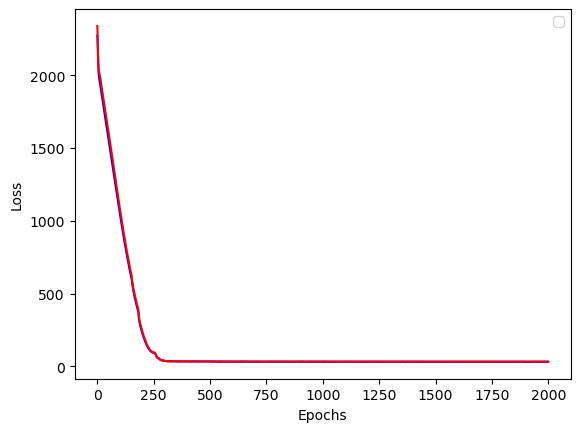

In [62]:


plt .plot(range(len(train_LOSS)), train_LOSS, color = 'blue')
plt.plot(range(len(valid_LOSS)), valid_LOSS, color = 'red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Inference

In [63]:
unmasked_dat = np.array(unmasked_data[0].detach().cpu())
unmasked_id = np.array(unmasked_idx[0].detach().cpu(), dtype=int)
masked_id = np.array(masked_idx[0].detach().cpu(), dtype=int)
# latent_ = np.array(latent[0].detach().cpu(), dtype=int)
label_ = np.array(label[0].detach().cpu())
pred_ = np.array(pred[0].detach().cpu())

unmask_cols = list(cols_name[unmasked_id])
mask_cols = list(cols_name[masked_id])
all_cols = unmask_cols + mask_cols

res = pd.DataFrame([pred_, label_], columns = all_cols)

print(f"unmasked_dat: {unmasked_dat.shape}")
print(f"unmasked_id: {unmasked_id.shape}")
print(f"masked_id: {masked_id.shape}")
print(f"label_: {label_.shape}")
print(f"pred_: {pred_.shape}")

res

unmasked_dat: (12,)
unmasked_id: (12,)
masked_id: (6,)
label_: (18,)
pred_: (18,)


,Grade,Internet_Access_at_Home,Family_Income_Level,Attendance (%),Final_Score,Assignments_Avg,Quizzes_Avg,Projects_Score,Study_Hours_per_Week,Age,Sleep_Hours_per_Night,Stress_Level (1-10),Gender,Department,Extracurricular_Activities,Parent_Education_Level,Midterm_Score,Total_Score
0,2.059013,0.930044,2.044164,80.956963,77.003777,83.814072,66.218658,93.624268,21.848301,24.665663,7.751856,5.317892,0.301193,1.054168,0.033243,1.413223,70.216843,76.649887
1,2.000000,1.000000,2.000000,80.300003,76.290001,83.419998,65.230003,93.500000,21.100000,24.000000,7.400000,5.000000,0.000000,1.000000,1.000000,0.000000,45.099998,50.220001
